In [1]:
import numpy as np
import torch
import torch_geometric
import open3d as o3d
#utils
import h5py
import os
import dataclasses

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss




Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


## Utils

### Load data

In [2]:
from utils.data import load_h5_data, PairData, PCDDataset
from torch_geometric.loader import DataLoader as PyGLoader

### Viz

In [3]:
from utils.viz import viz_many_mpl

### Configs

In [4]:
from dataclasses import dataclass, field


@dataclass
class ModelConfig:
    """Configuration for creating the model"""

    num_point: int = 256  # number of points per sample
    up_ratio: int = 4  # upsampling ratio
    dilation: int = 2  # dilation in DenseGCN
    num_neighbours: int = 20  # num neighbours in DenseGCN
    n_idgcn_blocks: int = 2  # number of inception dense blocks
    channels: int = 32  # number of channels for gcn
    n_dgcn_blocks: int = 3  # number of DenseGCNBlocks in the DenseGCN


@dataclass
class TrainConfig:
    """Configuration for the training step"""

    batch_size: int = 8
    epochs: int = 10
    optimizer = "adam"
    lr = 0.001
    beta = 0.9


@dataclass
class DataConfig:
    """Configuration for loading the data"""

    path: str = os.path.join(
        "data",
        "PU1K",
        "train",
        "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5",
    )  # path to data directory
    skip_rate: int = 5
    use_randominput: bool = True
    num_point: int = 256


@dataclass
class AllConfig:
    model_config: ModelConfig = field(default_factory=ModelConfig)
    train_config: TrainConfig = field(default_factory=TrainConfig)
    data_config: DataConfig = field(default_factory=DataConfig)


# Data

In [5]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")
data_config = DataConfig(
    path=data_path
)

train_config = TrainConfig()
model_config = ModelConfig()

In [6]:
dataset = PCDDataset(data_path, num_point=data_config.num_point, up_ratio=model_config.up_ratio, skip_rate=data_config.skip_rate)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 13800 samples


In [7]:
data = next(iter(dataset))
data_cloud, gt_cloud = data.pos_s, data.pos_t

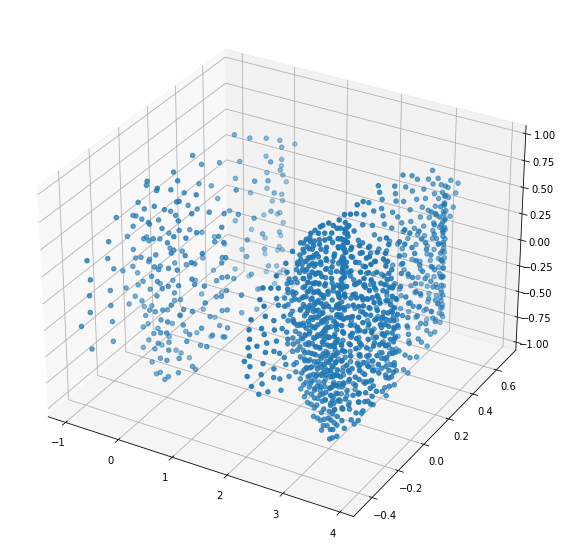

In [8]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([data_cloud, gt_cloud], ax = ax)

# Training

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
from pugcn_lib import PUGCN

In [11]:
dataset = PCDDataset(data_path, num_point=data_config.num_point, skip_rate=data_config.skip_rate)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 13800 samples


In [12]:
train_perc = .8
trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)])

In [13]:
# trainloader = DataLoader(trainset, batch_size=64)
# valloader = DataLoader(valset, batch_size=64, shuffle=False)
trainloader = PyGLoader(trainset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
valloader = PyGLoader(valset, batch_size=train_config.batch_size, shuffle=False, follow_batch = ['pos_s', 'pos_t'])


In [14]:
pugcn =  PUGCN(
    channels = model_config.channels,
    k = model_config.num_neighbours,
    r = model_config.up_ratio,
    n_idgcn_blocks=model_config.n_idgcn_blocks,
    n_dgcn_blocks=model_config.n_dgcn_blocks
).to(device)

loss_fn = loss_fn = ChamferLoss()
optimizer = torch.optim.Adam(params = pugcn.parameters(), lr = train_config.lr)

In [15]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [16]:
data_cloud.shape

torch.Size([256, 3])

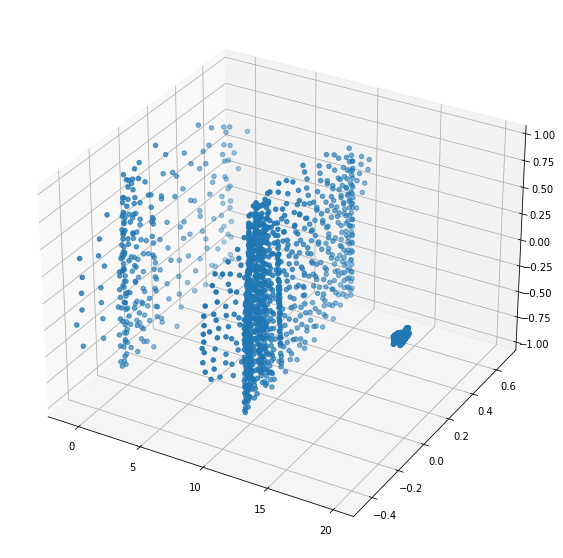

In [17]:
pred = pugcn(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

viz_many_mpl([data_cloud, gt_cloud, pred], d = 10, ax = ax)

In [18]:
def train(model, trainloader, loss_fn, optimizer):
    
    total_loss = 0.
    for d in (t:= tqdm(trainloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None
                    
        # get batch and target dimesnions since chamfer loss will need rehsaping
        b, nq = p_batch.max().item() + 1, q.shape[0] 
        
        # Train step
        optimizer.zero_grad()
        
        pred = model(p, batch = p_batch)
        d1, d2, _, _ = loss_fn(pred.reshape(b, nq // b, 3), q.reshape(b, nq // b, 3))
        loss = d1.mean() + d2.mean()
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss


@torch.no_grad()
def evaluate(model, valloader, loss_fn):
    
    total_loss = 0.
    for d in (t:= tqdm(valloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None
                    
        # get batch and target dimesnions since chamfer loss will need rehsaping
        b, nq = p_batch.max().item() + 1, q.shape[0] 
        
        pred = model(p, batch = p_batch)
        d1, d2, _, _ = loss_fn(pred.reshape(b, nq // b, 3), q.reshape(b, nq // b, 3))
        loss = d1.mean() + d2.mean()
        
        total_loss+=loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss
    

In [19]:
l = train(pugcn, trainloader, loss_fn, optimizer)

  0%|          | 0/1380 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
idx = np.random.choice(len(valset))
dv = valset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [30]:
pred = pugcn(sample.to(device)).cpu().detach().numpy()
pred

array([[ 0.03242502,  0.05065366, -0.02872162],
       [-0.08068872,  0.08094843, -0.15642434],
       [ 0.06861299, -0.07352027, -0.05082414],
       ...,
       [ 0.18320179, -0.1752994 , -0.5289355 ],
       [ 0.110374  , -0.10749933, -0.04336761],
       [ 0.06866033, -0.09703621, -0.01281191]], dtype=float32)

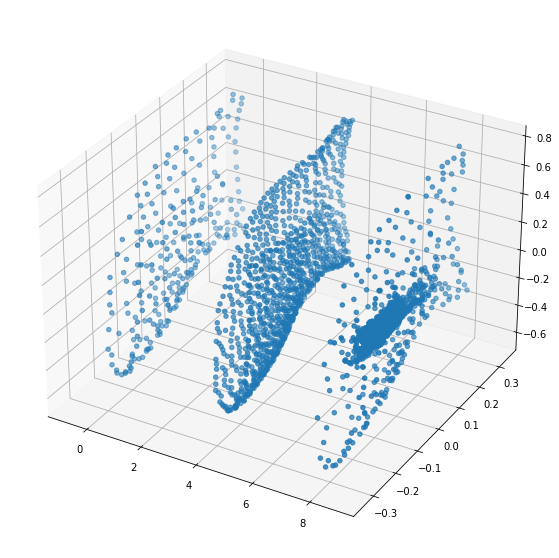

In [31]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([sample, gt, pred], d = 4, ax = ax)

In [214]:
valloader

In [216]:
l = evaluate(pugcn, valloader, loss_fn)
print(l)

  0%|          | 0/173 [00:00<?, ?it/s]

1.3365176753140986


In [33]:
torch.save({
            'epoch': 1,
            'model_state_dict': pugcn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join("trained-models", "ckpt1"))

In [34]:
checkpoint = torch.load(os.path.join("trained-models", "ckpt1"))

In [1]:
#checkpoint